In [535]:
# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.io import templates

templates.default = "plotly_white"
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Моделирование
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
import joblib

In [537]:
def load_and_process_data(client_path, credit_path, card_path, is_test=False):
    client_ds = pd.read_excel(client_path).drop_duplicates()
    credit_ds = pd.read_excel(credit_path).drop_duplicates()
    card_ds = pd.read_excel(card_path).drop_duplicates()

    # Объединение данных
    df = pd.concat([
        pd.merge(client_ds, credit_ds, on='CLIENT_ID', how='right'),
        pd.merge(client_ds, card_ds, on='CLIENT_ID', how='right')
    ]).copy(deep=True)
    if not is_test:
        df['TARGET'] = df['OVERDUE_IND'].fillna(df['СС_OVERDUE_IND'])
    df['TERM'] = df['TERM'].str.replace('M', '', regex=False)
    df['VALUE_DT'] = pd.to_datetime(df['VALUE_DT'], format='%d.%m.%Y', errors='coerce')
    df['OPEN_DT'] = pd.to_datetime(df['OPEN_DT'], format='%d.%m.%Y', errors='coerce')

    # Извлечение года, месяца, дня и дня недели
    df['OPEN_DT_YEAR'] = df['VALUE_DT'].dt.year
    df['OPEN_DT_MONTH'] = df['VALUE_DT'].dt.month
    df['OPEN_DT_DAY'] = df['VALUE_DT'].dt.day
    df['OPEN_DT_DAYOFWEEK'] = df['VALUE_DT'].dt.dayofweek

    # Извлечение года, месяца, дня и дня недели
    df['VALUE_DT_YEAR'] = df['VALUE_DT'].dt.year
    df['VALUE_DT_MONTH'] = df['VALUE_DT'].dt.month
    df['VALUE_DT_DAY'] = df['VALUE_DT'].dt.day
    df['VALUE_DT_DAYOFWEEK'] = df['VALUE_DT'].dt.dayofweek

    # Заполнение пропущенных значений
    df.fillna({
        'CREDIT_TYPE'        : -1,
        'CREDIT_PURCHASE'    : 'None',
        'PRODUCT_CODE_x'     : 'None',
        'TERM'               : -1,
        'ORIG_AMOUNT'        : -1,
        'CURR_RATE_NVAL'     : -1,
        'VALUE_DT'           : '1900-01-01',
        'CARD_TYPE'          : 'None',
        'PRODUCT_CODE_y'     : 'None',
        'CС_LIMIT_NVAL'      : -1,
        'СС_GRACE_PERIOD'    : -1,
        'CURR_RATE'          : -1,
        'OPEN_DT'            : '1900-01-01',
        "OPEN_DT_YEAR"       : -1,
        "OPEN_DT_MONTH"      : -1,
        "OPEN_DT_DAY"        : -1,
        "OPEN_DT_DAYOFWEEK"  : -1,
        "VALUE_DT_YEAR"      : -1,
        "VALUE_DT_MONTH"     : -1,
        "VALUE_DT_DAY"       : -1,
        "VALUE_DT_DAYOFWEEK" : -1,
        'AGE'                : -1,
        'REGION'             : 'None',
        'GENDER'             : -1,
        'JOB'                : -1,
        'INCOME'             : -1,
        'MARITAL_STATUS'     : 'None',
        'IP_FLAG'            : -1,
        'SME_FLAG'           : -1,
        'EMPLOYEE_FLAG'      : -1,
        'REFUGEE_FLAG'       : -1,
        'PDN'                : -1
    }, inplace=True)

    df['TERM'] = df['TERM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    # Удаление ненужных столбцов
    df = df.drop(['VALUE_DT', 'OPEN_DT', 'CLIENT_ID', 'ORGANIZATION', 'JOB', ], axis=1)
    if not is_test:
        df = df.drop(['OVERDUE_IND', 'СС_OVERDUE_IND'], axis=1)
    return df

# Пути к файлам
client_path = 'client_ds.xlsx'
credit_path = 'credit_ds.xlsx'
card_path = 'card_ds.xlsx'

# Загрузка и обработка данных
df = load_and_process_data(client_path, credit_path, card_path)
df

,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,CURR_RATE,TARGET,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
0,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
1,42,Краснодарский,2.0,60000.0,Неизвестно,0.0,0.0,0.0,0.0,125.9,...,-1.0,1.0,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
2,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
3,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
4,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,53,Санкт-Петербург,1.0,90000.0,Неизвестно,0.0,0.0,0.0,0.0,23.8,...,31.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1728,44,Новгородская,2.0,160000.0,Женат / замужем,0.0,0.0,0.0,0.0,20.1,...,33.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1729,34,Липецкая,2.0,70000.0,Неизвестно,0.0,0.0,0.0,0.0,46.3,...,14.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1730,33,Ленинградская,2.0,110000.0,Неизвестно,0.0,0.0,0.0,0.0,7.3,...,31.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [538]:
categorical_features = ['REGION', 'GENDER', 'MARITAL_STATUS', 'IP_FLAG', 'SME_FLAG', 'EMPLOYEE_FLAG', 'REFUGEE_FLAG', 'CREDIT_TYPE', 'CREDIT_PURCHASE', 'PRODUCT_CODE', 'CARD_TYPE', 'TARGET']

for column in categorical_features:
    df[column] = df[column].astype('category')
df

,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,CURR_RATE,TARGET,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
0,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
1,42,Краснодарский,2.0,60000.0,Неизвестно,0.0,0.0,0.0,0.0,125.9,...,-1.0,1.0,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
2,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
3,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
4,-1,None,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,53,Санкт-Петербург,1.0,90000.0,Неизвестно,0.0,0.0,0.0,0.0,23.8,...,31.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1728,44,Новгородская,2.0,160000.0,Женат / замужем,0.0,0.0,0.0,0.0,20.1,...,33.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1729,34,Липецкая,2.0,70000.0,Неизвестно,0.0,0.0,0.0,0.0,46.3,...,14.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1730,33,Ленинградская,2.0,110000.0,Неизвестно,0.0,0.0,0.0,0.0,7.3,...,31.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Предварительный анализ данных

Как видим, данные полные, пропусков нет.
Далее проверим данные на выбросы. Для начала сравним минимальное и максимальное значение со средним (для численных признаков):

In [539]:
info = pd.DataFrame()
info.index                    = df.columns
info['Тип данных']            = df.dtypes
info['Количество уникальных'] = df.nunique()
info['Количество пропусков']  = df.isna().sum()
info['Количество значений']   = df.count()
info

,Тип данных,Количество уникальных,Количество пропусков,Количество значений
AGE,int32,59,0,6409
REGION,category,80,0,6409
GENDER,category,3,0,6409
INCOME,float64,379,0,6409
MARITAL_STATUS,category,7,0,6409
IP_FLAG,category,3,0,6409
SME_FLAG,category,3,0,6409
EMPLOYEE_FLAG,category,2,0,6409
REFUGEE_FLAG,category,3,0,6409
PDN,float64,1264,0,6409


In [540]:
print("Основные статистики для числовых признаков:")
df.describe(include='all')

Основные статистики для числовых признаков:


,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,CURR_RATE,TARGET,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
count,6409.000000,6409,6409.0,6.409000e+03,6409,6409.0,6409.0,6409.0,6409.0,6409.000000,...,6409.000000,6409.0,6409.000000,6409.000000,6409.000000,6409.000000,6409.000000,6409.000000,6409.000000,6409.000000
unique,NaN,80,3.0,NaN,7,3.0,3.0,2.0,3.0,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,None,2.0,NaN,Неизвестно,0.0,0.0,0.0,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1125,3345.0,NaN,4012,5230.0,5230.0,5284.0,5283.0,NaN,...,NaN,4861.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.847402,NaN,NaN,6.632660e+04,NaN,NaN,NaN,NaN,NaN,44.695216,...,7.124949,NaN,1474.430800,4.650804,11.436418,1.496957,1474.430800,4.650804,11.436418,1.496957
std,19.831550,NaN,NaN,7.954465e+04,NaN,NaN,NaN,NaN,NaN,43.248551,...,15.177576,NaN,897.933231,4.503441,10.556269,2.166962,897.933231,4.503441,10.556269,2.166962
min,-1.000000,NaN,NaN,-1.000000e+00,NaN,NaN,NaN,NaN,NaN,-1.000000,...,-1.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,26.000000,NaN,NaN,3.000000e+04,NaN,NaN,NaN,NaN,NaN,14.600000,...,-1.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,38.000000,NaN,NaN,5.100000e+04,NaN,NaN,NaN,NaN,NaN,40.000000,...,-1.000000,NaN,2021.000000,5.000000,11.000000,1.000000,2021.000000,5.000000,11.000000,1.000000
75%,49.000000,NaN,NaN,8.500000e+04,NaN,NaN,NaN,NaN,NaN,63.800000,...,14.900000,NaN,2022.000000,9.000000,21.000000,3.000000,2022.000000,9.000000,21.000000,3.000000


# Моделирование

## Выбор модели

Разделим решение на 2 части:
1) "Банковское": логистическая регрессия + WOE. Выбор обоснован тем, что Логистическая Регрессия хорошо интерпретируема и используется в реальном банковском моделировании рисков. Однако, Логистическая Регрессия не работает с категориальными признаками, вернее сказать, что работает, но для этого значения категориальных признаков должны быть сравнимы. В том числе для этого вводится понятие WOE (Weight of evidence).
2) Свободное от ограничений решение: нейронные сети

In [541]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

import time

### Преобразование категориальных переменных

Сделаем кодирование категориальных переменных с помощью LabelEncoder из библиотеки Scikit-Learn. Это преобразует категории в числа, что необходимо для использования этих данных в большинстве алгоритмов машинного обучения.

Целевая переменная `y` кодируется как 1 для "yes" и 0 для "no". Это стандартный подход для бинарной классификации в машинном обучении, где нужно предсказать одно из двух состояний.

#### Label Encoding

Формула кодирования конкретной категории $C$ в число может быть представлена как: $ \text{code}(C) = i $
где $i$ — порядковый номер категории $C$ в данных.

#### Общие формулы и принципы

В процессе предобработки данных могут использоваться следующие операции и принципы:

- Нормализация**: приведение всех числовых переменных к единому масштабу, чтобы улучшить сходимость алгоритма. Обычно используется Min-Max scaling или Z-score стандартизация.
- One-hot Encoding**: преобразование категориальных переменных в бинарные векторы; применяется, когда порядок категорий не имеет значения.
- Отбор признаков: удаление нерелевантных или малоинформативных признаков для упрощения модели и улучшения её обобщающей способности.

Эти методы помогают подготовить данные для эффективного обучения моделей машинного обучения.

In [542]:
categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int', 'int32', 'int64', 'float64']).columns.tolist()

def encode_features(df, features):
    encoders = {}
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
        encoders[feature] = le

    return df, encoders


df_encoded, encoders = encode_features(df, categorical_features)

df_raw = df.copy(deep=True)
df = df_encoded.copy(deep=True)
df

,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,CURR_RATE,TARGET,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
0,-1,0,0,-1.0,0,0,0,0,0,-1.0,...,-1.0,1,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
1,42,30,2,60000.0,5,1,1,1,1,125.9,...,-1.0,1,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
2,-1,0,0,-1.0,0,0,0,0,0,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
3,-1,0,0,-1.0,0,0,0,0,0,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
4,-1,0,0,-1.0,0,0,0,0,0,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,53,55,1,90000.0,5,1,1,1,1,23.8,...,31.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1728,44,43,2,160000.0,3,1,1,1,1,20.1,...,33.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1729,34,35,2,70000.0,5,1,1,1,1,46.3,...,14.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1730,33,34,2,110000.0,5,1,1,1,1,7.3,...,31.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Логистическая регрессия + WOE

## Введение в WOE (Weight of Evidence)
WOE (Weight of Evidence) обеспечивает полезный способ обработки и преобразования категориальных переменных в числовые, что является особенно важным для алгоритмов машинного обучения, таких как логистическая регрессия, которые требуют числового ввода. WOE также позволяет интерпретировать влияние предикторов после преобразования. Перед тем как применять WOE, часто целесообразно разбить числовые признаки на интервалы. Процесс разбиения может быть автоматизирован с помощью методов, таких как деревья решений, которые помогают определить оптимальные точки разбиения.
### Решение
WOE можно считать для числовых признаков, однако, учитывая формулу WOE, делать это для числовых признаков не очень правильно. Лучше разбить диапазон значений на интервалы, закодировать их и посчитать WOE. Отсюда вытекает задача, как оптимально разбить значения признаков на интервалы. Для решения этой задачи, мы решили для каждого признака обучать DecisionTreeClassifier и из него получать границы разбиение признака, при которых score максимальный.

### Получение границ разбиения
Рассчитаем границы разбиений для каждого признака. Посмотрим параметры дерева, которое делит признаки на интервалы, а также на само разбиение.

#### Определение функции get_boundaries
Функция `get_boundaries(x_boundaries, y_boundaries)` определяет оптимальные параметры для дерева решений и вычисляет границы разбиений для признаков.

##### StratifiedKFold
`StratifiedKFold` используется для улучшения валидации модели, сохраняя процентные соотношения каждого класса в каждом фолде, что особенно важно в случае несбалансированных данных.

##### GridSearchCV
`GridSearchCV` - это метод для систематической работы с множеством различных комбинаций параметров, позволяя через перекрестную проверку определить, какая комбинация дает наилучшую производительность.


In [543]:
# Функция, которая возвращает границы разбиений
def get_bondaries(x_bondaries, y_bondaries):
    parameters = {
        'max_depth': [x for x in range(1, 9)],
        'min_samples_leaf': [5, 10, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 20000]
    }
    dtc = DecisionTreeClassifier(random_state=17)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    clf = GridSearchCV(dtc, parameters, scoring='roc_auc', cv=skf)
    clf.fit(pd.DataFrame(x_bondaries), y_bondaries)
    print('Best parameters for DT: ', clf.best_params_)
    print('ROC_AUC score: ', round(clf.best_score_, 4))
    tree = clf.best_estimator_
    tree.fit(pd.DataFrame(x_bondaries), y_bondaries)
    print('Boundaries: ', np.sort([x for x in tree.tree_.threshold if x != -2]))
    return np.sort([x for x in tree.tree_.threshold if x != -2])

In [544]:
# Функция для кэширования и загрузки границ
def load_or_compute_boundaries(df, categorical_features, cache_path="boundaries_cache.pkl"):
    if os.path.exists(cache_path):
        boundaries = joblib.load(cache_path)
    else:
        boundaries = dict()
        for col in categorical_features:
            if col != 'OVERDUE_IND':
                boundaries[col] = get_bondaries(df[col], df["TARGET"])
        joblib.dump(boundaries, cache_path)
    return boundaries


boundaries = load_or_compute_boundaries(df, categorical_features)

### Зачем мы разделили диапазон значений на интервалы

#### Дискретизация признаков
Одной из целей использования границ разбиения является **дискретизация непрерывных переменных**. Дискретизация (или биннинг) преобразует непрерывные переменные в категориальные, что может помочь улучшить производительность некоторых алгоритмов классификации, уменьшить влияние выбросов и упростить модель, делая ее интерпретируемой.

#### Улучшение интерпретируемости
Категории, полученные в результате дискретизации, позволяют легче интерпретировать влияние признаков на модель, поскольку каждый интервал можно анализировать отдельно в контексте целевой переменной.

#### Кодирование Weight of Evidence (WOE)
После дискретизации признаков значения, присвоенные каждому интервалу, используются для расчета **Weight of Evidence (WOE)**. WOE является мощной техникой в кредитном скоринге и риск-менеджменте, позволяющей оценить влияние предиктора на вероятность наступления события (например, дефолта по кредиту).

Формула для расчета WOE для каждой группы:
$$ \text{WOE} = \ln \left(\frac{\text{Распределение хороших клиентов}}{\text{Распределение плохих клиентов}}\right) $$
где "хорошие" и "плохие" клиенты - это классы в вашей целевой переменной `y`.

#### Пример использования

В вашем контексте, дискретизация и последующий расчет WOE могут помочь в следующем:
- **Улучшение производительности моделей**: Некоторые алгоритмы, особенно логистическая регрессия, работают лучше, если предикторы кодируются через WOE.
- **Управление риском**: Расчет WOE позволяет более точно оценить вклад каждого признака в риск, что критически важно в финансовой сфере.
- **Повышение интерпретируемости**: Интервалы и соответствующие им значения WOE можно легко интерпретировать и объяснить в бизнес-терминах, что делает модель более прозрачной.

#### Использование WOE

1. Разделение Переменных: Прежде чем можно вычислить WOE, необходимо разделить каждый признак на группы (используя функцию splitter и границы, найденные ранее). Это позволяет сравнивать разные уровни риска в разных группах переменных.
2. Преобразование в WOE: После разделения переменных значения в каждой группе преобразуются в WOE, что помогает в оценке влияния каждой группы на вероятность исхода.
3. Интерпретация: Больший WOE указывает на больший риск (или меньшую вероятность хорошего исхода), а меньший WOE — на меньший риск


In [545]:
# Функция, которая режет признак на интервалы и кодирует их
def splitter(x, col_bondaries):
    for i in range(len(col_bondaries)):
        if i > 0:
            if x > col_bondaries[i - 1] and x <= col_bondaries[i]:
                return i
        if i == 0:
            if x <= col_bondaries[i]:
                return i
        if i == len(col_bondaries) - 1:
            if x > col_bondaries[i]:
                return i + 1

# Функция расчёта WOE
def WOE(x, y):
    df = pd.DataFrame({'x': x, 'y': y})
    good = df.groupby('x')['y'].sum() / np.sum(df['y'])
    bad = (df.groupby('x')['y'].count() - df.groupby('x')['y'].sum()) / (len(df['y']) - np.sum(df['y']))
    WOE = np.log((good + 0.000001) / bad)
    WOE = pd.Series(WOE).to_dict()
    return x.apply(lambda x: WOE.get(x))

In [546]:
# df['TARGET'] = df['TARGET'].astype('int64')
data_woe = pd.DataFrame()
for col in df.columns:
    if col != 'TARGET' and col not in numerical_features + ['CREDIT_PURCHASE']:
        data_woe[col] = df[col].apply(lambda x: splitter(x, boundaries[col]))
        data_woe[col] = WOE(data_woe[col], df['TARGET'])
    else:
        data_woe[col] = df[col]

data_woe

,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,CURR_RATE,TARGET,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
0,-1,3.079064,3.079064,-1.0,3.079064,3.014613,3.014613,3.079064,3.079064,-1.0,...,-1.0,1,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
1,42,-0.820708,-1.081498,60000.0,-0.731695,-1.040897,-1.040897,-0.978243,-0.978243,125.9,...,-1.0,1,2019.0,2.0,21.0,3.0,2019.0,2.0,21.0,3.0
2,-1,3.079064,3.079064,-1.0,3.079064,3.014613,3.014613,3.079064,3.079064,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
3,-1,3.079064,3.079064,-1.0,3.079064,3.014613,3.014613,3.079064,3.079064,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
4,-1,3.079064,3.079064,-1.0,3.079064,3.014613,3.014613,3.079064,3.079064,-1.0,...,-1.0,1,2019.0,2.0,25.0,0.0,2019.0,2.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,53,-1.568766,-0.817633,90000.0,-0.731695,-1.040897,-1.040897,-0.978243,-0.978243,23.8,...,31.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1728,44,-2.050148,-1.081498,160000.0,-2.422031,-1.040897,-1.040897,-0.978243,-0.978243,20.1,...,33.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1729,34,-1.040693,-1.081498,70000.0,-0.731695,-1.040897,-1.040897,-0.978243,-0.978243,46.3,...,14.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1730,33,-1.040693,-1.081498,110000.0,-0.731695,-1.040897,-1.040897,-0.978243,-0.978243,7.3,...,31.9,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Information Value (IV)

**Information Value (IV)** - это метрика, используемая для оценки предиктивной способности или силы признака в контексте бинарной классификации. Эта метрика помогает определить, насколько хорошо переменная может различать две группы (например, дефолт/не дефолт в кредитном скоринге). IV рассчитывается на основе Weight of Evidence (WOE), которая была рассчитана на предыдущих шагах.

#### Формула для расчёта IV:

$$ IV = \sum_{i} (\text{Good}_i - \text{Bad}_i) \times \text{WOE}_i $$

где:
- $Good_i$ - доля "хороших" клиентов (например, тех, кто своевременно выплачивает кредит) в группе $i$,
- $Bad_i$ - доля "плохих" клиентов в той же группе,
- $WOE_i$ - Weight of Evidence для группы $i $.

### Применение и интерпретация IV

- **Низкое значение IV** (меньше 0.1) указывает, что переменная имеет очень слабую предиктивную способность.
- **Среднее значение IV** (0.1 до 0.3) говорит о средней предиктивной способности.
- **Высокое значение IV** (больше 0.3) показывает, что переменная является сильным предиктором.

### Описание функции `Information_Value`

Функция `Information_Value(x, y)` вычисляет IV для переданного признака `x` и целевой переменной `y`:

1. Создаёт DataFrame для удобства группировки и работы с данными.
2. Группирует данные по признаку `x` и рассчитывает долю хороших и плохих исходов в каждой группе.
3. Вычисляет WOE для каждой группы.
4. Рассчитывает IV, используя формулу указанную выше.
5. Возвращает суммарный IV для признака.

Посмотрим на Information Value категориальных признаков:

In [547]:
# Функция расчёта Information Value
def Information_Value(x, y):
    df = pd.DataFrame({'x': x, 'y': y})
    good = df.groupby('x')['y'].sum() / np.sum(df['y'])
    bad = (df.groupby('x')['y'].count() - df.groupby('x')['y'].sum()) / (len(df['y']) - np.sum(df['y']))
    WOE = np.log((good + 0.000001) / bad)
    IV = (good - bad) * WOE
    return IV.sum()

In [548]:
for feature in data_woe.columns:
    print('IV of ', feature, ' = ', min(Information_Value(data_woe[feature], df['TARGET']).round(2), 3.00), '\n')

IV of  AGE  =  2.57 

IV of  REGION  =  2.54 

IV of  GENDER  =  2.47 

IV of  INCOME  =  3.0 

IV of  MARITAL_STATUS  =  2.73 

IV of  IP_FLAG  =  2.54 

IV of  SME_FLAG  =  2.54 

IV of  EMPLOYEE_FLAG  =  2.46 

IV of  REFUGEE_FLAG  =  2.46 

IV of  PDN  =  3.0 

IV of  CREDIT_TYPE  =  0.74 

IV of  CREDIT_PURCHASE  =  3.0 

IV of  PRODUCT_CODE  =  1.36 

IV of  TERM  =  3.0 

IV of  ORIG_AMOUNT  =  3.0 

IV of  CURR_RATE_NVAL  =  3.0 

IV of  CARD_TYPE  =  0.53 

IV of  CС_LIMIT_NVAL  =  3.0 

IV of  СС_GRACE_PERIOD  =  3.0 

IV of  CURR_RATE  =  0.85 

IV of  TARGET  =  3.0 

IV of  OPEN_DT_YEAR  =  3.0 

IV of  OPEN_DT_MONTH  =  0.62 

IV of  OPEN_DT_DAY  =  0.57 

IV of  OPEN_DT_DAYOFWEEK  =  0.62 

IV of  VALUE_DT_YEAR  =  3.0 

IV of  VALUE_DT_MONTH  =  0.62 

IV of  VALUE_DT_DAY  =  0.57 

IV of  VALUE_DT_DAYOFWEEK  =  0.62 



In [549]:
corr = data_woe.corr().round(2)
fig1 = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    colorscale='ice',
    annotation_text=corr.values
)
fig1.update_layout(height=800)

# Выбираем только корреляцию с целевым признаком 'cnt'
corr = corr['TARGET'].drop('TARGET')
corr = corr[abs(corr).argsort()]
fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=corr.values,
    y=corr.index,
    orientation='h',
    marker_color=list(range(len(corr.index)))
))
fig2.update_layout(
    title='Корреляция с TARGET',
    height=700,
    xaxis=dict(title='Признак'),  # Название оси x
    yaxis=dict(title='Корреляция'),
)
fig1.show()
fig2.show()

In [550]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import  SMOTE

smote = SMOTE()
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Применение SMOTE к данным
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled , test_size=0.3,
    stratify=y_resampled,
    random_state=17
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [551]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Reloading Tuner from tuner_dir\complex_nn_model\tuner0.json
Search space summary
Default search space size: 14
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_input (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, '

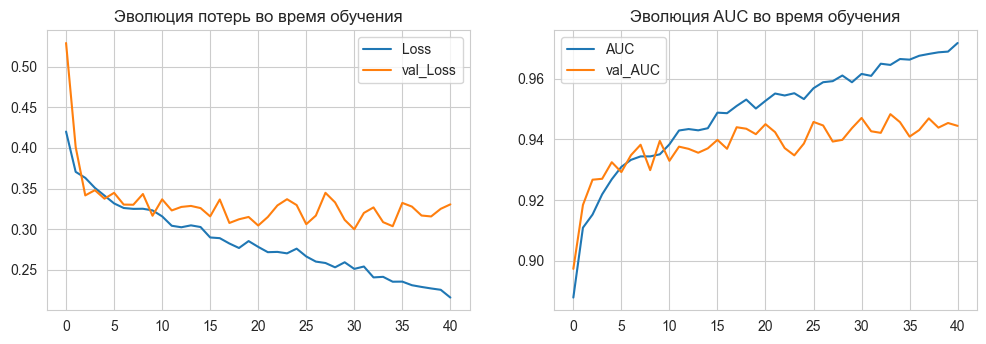

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Результат обучения:
Точность модели: 92.55%
_______________________________________________
Отчет по классификации:
                     0            1  accuracy    macro avg  weighted avg
precision     0.932239     0.918958  0.925496     0.925598      0.925599
recall        0.917720     0.933275  0.925496     0.925497      0.925496
f1-score      0.924922     0.926061  0.925496     0.925492      0.925492
support    3403.000000  3402.000000  0.925496  6805.000000   6805.000000
_______________________________________________
Матрица ошибок: 
 [[3123  280]
 [ 227 3175]]

Результат тестирования:
Точность модели: 87.83%
_______________________________________________
Отчет по классификации:
                     0            1  accuracy    macro avg  weighted avg
precision     0.892527     0.865079    0.8783     0.878803      0.878798
recall        0.860082     0.896504    0.8783     0.878293      0.878300
f1-sco

In [552]:
from kerastuner.tuners import RandomSearch
import os


def build_model(hp):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(units=hp.Int('units_input', min_value=64, max_value=512, step=32), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1))(x)

    for i in range(hp.Int('num_layers', 1, 5)):
        x = Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=32), activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1))(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[AUC(name='AUC')]
    )
    return model


tuner_dir = 'tuner_dir'
project_name = 'complex_nn_model'

if not os.path.exists(tuner_dir):
    os.makedirs(tuner_dir)

tuner = RandomSearch(
    build_model,
    objective='val_AUC',
    max_trials=50,
    executions_per_trial=2,
    directory=tuner_dir,
    project_name=project_name
)

# Проверяем, существует ли уже сохранённый поиск
if os.path.exists(os.path.join(tuner_dir, project_name, "oracle.json")):
    tuner.reload()

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Лучшие гиперпараметры:
- units_input: {best_hps.get('units_input')}
- dropout_input: {best_hps.get('dropout_input')}
- num_layers: {best_hps.get('num_layers')}
- units per layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- dropout per layer: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}
- learning_rate: {best_hps.get('lr')}
""")

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


def evaluate_nn(true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    if train:
        print("Результат обучения:\n================================================")
    else:
        print("Результат тестирования:\n================================================")
    print(f"Точность модели: {accuracy_score(true, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Отчет по классификации:\n{clf_report}")
    print("_______________________________________________")
    print(f"Матрица ошибок: \n {confusion_matrix(true, pred)}\n")


def plot_learning_evolution(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.title('Эволюция потерь во время обучения')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(history.history['AUC'], label='AUC')
    plt.plot(history.history['val_AUC'], label='val_AUC')
    plt.title('Эволюция AUC во время обучения')
    plt.legend()
    plt.show()


plot_learning_evolution(history)

# Предсказания на тренировочной и тестовой выборках
y_train_pred = (best_model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")


def plot_confusion_matrix(y_true, y_pred, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(3)

    fig = px.imshow(
        cm, labels=dict(x="Предсказанный класс", y="Истинный класс"), x=['Нет', 'Да'], y=['Нет', 'Да'],
        title='Нормализованная матрица ошибок' if normalize else 'Матрица ошибок',
        color_continuous_scale='Blues'
    )

    fig.update_xaxes(tickangle=45, tickmode='array', tickvals=np.arange(2), ticktext=['Нет', 'Да'])
    fig.update_yaxes(tickangle=45, tickmode='array', tickvals=np.arange(2), ticktext=['Нет', 'Да'])
    # Добавление надписей
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            fig.add_annotation(
                x=i, y=j,
                text=str(cm[j, i]),
                showarrow=False,
                font=dict(color="white" if cm[j, i] > thresh else "black"),
                align="center"
            )
    return fig

# Оценка модели на тренировочных данных
evaluate_nn(y_train, y_train_pred, train=True)
plot_confusion_matrix(y_train, y_train_pred)


# Оценка модели на тестовых данных
evaluate_nn(y_test, y_test_pred, train=False)
plot_confusion_matrix(y_test, y_test_pred)


In [575]:
import json

with open('history.json', 'w') as f:
    json.dump(history.history, f)

### Information Value (IV)

**Information Value (IV)** - это метрика, используемая для оценки предиктивной способности или силы признака в контексте бинарной классификации. Эта метрика помогает определить, насколько хорошо переменная может различать две группы (например, дефолт/не дефолт в кредитном скоринге). IV рассчитывается на основе Weight of Evidence (WOE), которая была рассчитана на предыдущих шагах.

#### Формула для расчёта IV:

$$ IV = \sum_{i} (\text{Good}_i - \text{Bad}_i) \times \text{WOE}_i $$

где:
- $Good_i$ - доля "хороших" клиентов (например, тех, кто своевременно выплачивает кредит) в группе $i$,
- $Bad_i$ - доля "плохих" клиентов в той же группе,
- $WOE_i$ - Weight of Evidence для группы $i $.

### Применение и интерпретация IV

- **Низкое значение IV** (меньше 0.1) указывает, что переменная имеет очень слабую предиктивную способность.
- **Среднее значение IV** (0.1 до 0.3) говорит о средней предиктивной способности.
- **Высокое значение IV** (больше 0.3) показывает, что переменная является сильным предиктором.

### Описание функции `Information_Value`

Функция `Information_Value(x, y)` вычисляет IV для переданного признака `x` и целевой переменной `y`:

1. Создаёт DataFrame для удобства группировки и работы с данными.
2. Группирует данные по признаку `x` и рассчитывает долю хороших и плохих исходов в каждой группе.
3. Вычисляет WOE для каждой группы.
4. Рассчитывает IV, используя формулу указанную выше.
5. Возвращает суммарный IV для признака.

### Выводы по IV признаков

- Признаки с очень высоким IV, такие как `emp.var.rate`, `cons.price.idx`, и `cons.conf.idx` (IV > 1), являются очень мощными предикторами и должны быть включены в модель.
- Признаки с IV близким к 0, как `loan` и `day_of_week`, имеют низкую предиктивную способность по отношению к целевой переменной.

Эти инсайты помогают в оптимизации и улучшении моделей машинного обучения, особенно в задачах кредитного скоринга и риск-менеджмента, позволяя фокусироваться на наиболее информативных переменных.



Посмотрим на Information Value категориальных признаков:

In [553]:
# parameters = {'penalty': ['l1', 'l2'], 'C': [0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01], 'class_weight': [None, 'balanced']}
# LR = LogisticRegression(random_state=17, n_jobs=-1)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
# clf_lr = GridSearchCV(LR, parameters, scoring='roc_auc', cv=skf)
# # clf_lr.fit(data_woe.drop('TARGET', axis=1), data_woe['TARGET'])
# clf_lr.fit(data_woe.drop('TARGET', axis=1), data_woe['TARGET'])
# print('Best parameters: ', clf_lr.best_params_)
# print('ROC_AUC score: ', round(clf_lr.best_score_, 4))

In [554]:
from sklearn.utils.class_weight import compute_class_weight

cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

LR_control = LogisticRegression(class_weight='balanced', C=0.09, penalty='l2', solver='liblinear')
# LR_control = LogisticRegression(C=0.04, penalty='l2')
LR_control.fit(X_train, y_train)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, LR_control.predict_proba(X_test)[:, 1]), 4))

ROC_AUC on Control data:  0.8906


In [555]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name='ROC кривая (AUC = %0.4f)' % roc_auc_score(y_true, y_prob)
    ))
    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        line=dict(dash='dash'),
        name='Диагональ'
    ))

    fig.update_layout(
        xaxis_title='Доля ложно-положительных результатов',
        yaxis_title='Доля истинно-положительных результатов',
        title='Кривая ROC',
        width=900
    )
    fig.show()


def score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        prob = clf.predict_proba(X_train)[:, 1]
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Результат обучения:\n================================================")
        print(f"Точность модели: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ОТЧЕТ ПО КЛАССИФИКАЦИИ:\n{clf_report}")
        print("_______________________________________________")
        # Визуализация ROC-кривой
        plot_roc_curve(y_train, prob)
        # Визуализация матрицы ошибок
        plot_confusion_matrix(y_train, pred, normalize=True).show()

    else:
        pred = clf.predict(X_test)
        prob = clf.predict_proba(X_test)[:, 1]
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Результат тестирования:\n================================================")
        print(f"Точность модели: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ОТЧЕТ ПО КЛАССИФИКАЦИИ:\n{clf_report}")
        print("_______________________________________________")
        # Визуализация ROC-кривой
        plot_roc_curve(y_test, prob)
        # Визуализация матрицы ошибок
        plot_confusion_matrix(y_test, pred, normalize=True).show()
score(LR_control, X_train, y_train, X_test, y_test, train=True)
score(LR_control, X_train, y_train, X_test, y_test, train=False)

Результат обучения:
Точность модели: 82.48%
_______________________________________________
ОТЧЕТ ПО КЛАССИФИКАЦИИ:
                     0            1  accuracy    macro avg  weighted avg
precision     0.754782     0.948094  0.824835     0.851438      0.851424
recall        0.962386     0.687243  0.824835     0.824814      0.824835
f1-score      0.846035     0.796864  0.824835     0.821449      0.821453
support    3403.000000  3402.000000  0.824835  6805.000000   6805.000000
_______________________________________________


Результат тестирования:
Точность модели: 82.65%
_______________________________________________
ОТЧЕТ ПО КЛАССИФИКАЦИИ:
                     0            1  accuracy    macro avg  weighted avg
precision     0.761538     0.934366  0.826534     0.847952      0.847982
recall        0.950617     0.702536  0.826534     0.826577      0.826534
f1-score      0.845638     0.802034  0.826534     0.823836      0.823829
support    1458.000000  1459.000000  0.826534  2917.000000   2917.000000
_______________________________________________


In [556]:
# Получение коэффициентов и интерсепта
coef = LR_control.coef_[0]
intercept = LR_control.intercept_[0]

# Вывод формулы в формате Markdown
formula = f"z = {intercept:.3f}"
variables = X_train.columns

for var, c in zip(variables, coef):
    sign = "+" if c >= 0 else "-"
    formula += f" {sign} {abs(c):.3f} \\cdot {var}"

print("```markdown")
print(f"Где\n\n\\[ {formula} \\]")
print("```")

```markdown
Где

\[ z = 1.274 - 0.772 \cdot AGE - 0.198 \cdot REGION - 1.463 \cdot GENDER - 0.070 \cdot INCOME + 1.000 \cdot MARITAL_STATUS - 1.682 \cdot IP_FLAG - 1.682 \cdot SME_FLAG - 0.885 \cdot EMPLOYEE_FLAG - 0.447 \cdot REFUGEE_FLAG + 0.359 \cdot PDN - 0.522 \cdot CREDIT_TYPE + 0.268 \cdot CREDIT_PURCHASE + 0.624 \cdot PRODUCT_CODE - 0.546 \cdot TERM - 0.446 \cdot ORIG_AMOUNT + 1.187 \cdot CURR_RATE_NVAL + 0.511 \cdot CARD_TYPE - 0.152 \cdot CС_LIMIT_NVAL - 1.684 \cdot СС_GRACE_PERIOD + 1.012 \cdot CURR_RATE + 0.610 \cdot OPEN_DT_YEAR - 0.050 \cdot OPEN_DT_MONTH + 0.149 \cdot OPEN_DT_DAY - 0.193 \cdot OPEN_DT_DAYOFWEEK + 0.610 \cdot VALUE_DT_YEAR - 0.050 \cdot VALUE_DT_MONTH + 0.149 \cdot VALUE_DT_DAY - 0.193 \cdot VALUE_DT_DAYOFWEEK \]
```


In [557]:
# Чтение тестовых данных
test_client_path = 'client_ds_копия.xlsx'
test_credit_path = 'credit_ds_копия.xlsx'
test_card_path = 'card_ds_копия.xlsx'
test_df = load_and_process_data(test_client_path, test_credit_path, test_card_path, is_test=True)

# Кодирование категориальных признаков в тестовых данных
for feature, le in encoders.items():
    try:
        test_df[feature] = le.transform(test_df[feature])
    except ValueError as e:
        # Замена отсутствующих значений на le.classes_[0]
        test_df[feature] = test_df[feature].apply(
            lambda x: le.classes_[0] if x not in le.classes_ else x
        )
        test_df[feature] = le.transform(test_df[feature])
    except KeyError as e: continue

In [558]:
# test_data_woe = pd.DataFrame()
# for col in test_df.columns:
#     if col != 'TARGET' and col not in numerical_features + ['CREDIT_PURCHASE']:
#         test_data_woe[col] = test_df[col].apply(lambda x: splitter(x, boundaries.get(col)))
#         test_data_woe[col] = test_data_woe[col].map(data_woe[col].dropna().to_dict())
#     elif col!='TARGET':
#         test_data_woe[col] = test_df[col]


In [578]:
X_test

,AGE,REGION,GENDER,INCOME,MARITAL_STATUS,IP_FLAG,SME_FLAG,EMPLOYEE_FLAG,REFUGEE_FLAG,PDN,...,СС_GRACE_PERIOD,CURR_RATE,OPEN_DT_YEAR,OPEN_DT_MONTH,OPEN_DT_DAY,OPEN_DT_DAYOFWEEK,VALUE_DT_YEAR,VALUE_DT_MONTH,VALUE_DT_DAY,VALUE_DT_DAYOFWEEK
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.995915,0.797190,0.849458,0.142857,0.995915,0.797190,0.849458,0.142857
1,0.935897,0.481013,1.0,0.010000,0.500000,0.5,0.5,1.0,0.5,0.075920,...,0.000000,0.00000,0.999506,0.230769,0.156250,0.857143,0.999506,0.230769,0.156250,0.857143
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.996049,0.153846,0.750000,0.857143,0.996049,0.153846,0.750000,0.857143
3,0.602564,0.240506,0.5,0.041667,0.833333,0.5,0.5,1.0,0.5,0.032293,...,0.000000,0.00000,0.998519,0.615385,0.843750,0.142857,0.998519,0.615385,0.843750,0.142857
4,0.602564,0.632911,1.0,0.015667,1.000000,0.5,0.5,1.0,0.5,0.004598,...,0.000000,0.00000,0.999506,0.846154,1.000000,0.285714,0.999506,0.846154,1.000000,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.997531,0.230769,0.906250,0.571429,0.997531,0.230769,0.906250,0.571429
2913,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.996594,0.724847,0.241593,0.639191,0.996594,0.724847,0.241593,0.639191
2914,0.564103,0.379747,0.5,0.010000,0.833333,0.5,0.5,1.0,0.5,0.033576,...,0.000000,0.00000,0.998519,0.384615,0.875000,0.285714,0.998519,0.384615,0.875000,0.285714
2915,0.730769,0.367089,1.0,0.027859,0.833333,0.0,0.0,1.0,0.5,0.087184,...,0.000000,0.00000,0.998519,0.615385,0.667609,0.443726,0.998519,0.615385,0.667609,0.443726


In [577]:
LR_control.predict_proba(X_test)

array([[0.04560825, 0.95439175],
       [0.84093587, 0.15906413],
       [0.030223  , 0.969777  ],
       ...,
       [0.52710339, 0.47289661],
       [0.32371781, 0.67628219],
       [0.74084801, 0.25915199]])

In [559]:
# Проверяем и нормализуем тестовые данные
X_test_df  = scaler.transform(test_df)

In [567]:
pred = (best_model.predict(X_test_df) > 0.5).astype("int32")
sum(pred)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([175])

In [568]:
pred = LR_control.predict(X_test_df)
sum(pred)

48